### Spectral Synthesis & Emission-Line Fitting

The purpose of this notebook is to sandbox a new spectral synthesis fitting code.

In [3]:
import os, scipy, pdb
import numpy as np 
import fitsio
import multiprocessing

In [108]:
from astropy.modeling import Fittable1DModel, Parameter
from astropy.table import Table
import desispec.io

In [5]:
from scipy import constants
C_LIGHT = constants.c / 1000.0 # [km/s]

import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pitr63sj because the default path (/homedir/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Top-level directories. Need to remember to move the script CKC2fits.py into a repository somewhere.

In [6]:
ssppath = os.path.join(os.getenv('DESI_ROOT'), 'users', 'ioannis', 'fsps') # need a variable for this
truthdir = os.path.join(os.getenv('DESI_ROOT'), 'sv', 'vi', 'TruthTables')
specprod_dir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'redux', 'andes')

### Read the data

In [7]:
def get_data(tile='66003', night='20200315'):
    """ELG - tile='70005', night='20200228'
    
    https://desi.lbl.gov/trac/wiki/SurveyValidation/TruthTables
    """
    from astropy.table import join, vstack
    from desispec.spectra import Spectra

    datadir = os.path.join(specprod_dir, 'tiles', tile, night)
    
    print('Working on tile, night {}, {}'.format(tile, night))

    if tile == '66003':
        truthfile = os.path.join(truthdir, 'truth_table_BGS_v1.2.csv')
    elif tile == '70500':
        truthfile = os.path.join(truthdir, 'truth_table_ELG_v1.2_latest.csv')
    else:
        raise ValueError('Fix me.')
    truth = Table.read(truthfile)
    best = np.where(
        (truth['best quality'] >= 2.5) * 
        (truth['Redrock spectype'] == 'GALAXY') *
        (truth['Redrock z'] < 0.75) 
    )[0]
    #goodobj = np.where((zb['DELTACHI2'] > 100) * (zb['ZWARN'] == 0) * (zb['SPECTYPE'] == 'GALAXY'))[0]
    
    print('Read {}/{} good redshifts from {}'.format(len(best), len(truth), truthfile))
    truth = truth[best]
    
    zbest = []
    spectra, keepindx = [], []
    for spectro in ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'):
        zbestfile = os.path.join(datadir, 'zbest-{}-{}-{}.fits'.format(spectro, tile, night))
        coaddfile = os.path.join(datadir, 'coadd-{}-{}-{}.fits'.format(spectro, tile, night))
        if os.path.isfile(zbestfile) and os.path.isfile(coaddfile):
            zb = Table(fitsio.read(zbestfile))
            keep = np.where(np.isin(zb['TARGETID'], truth['TARGETID']))[0]
            print('Spectrograph {}: N={}'.format(spectro, len(keep)))
            if len(keep) > 0:
                zbest.append(zb[keep])
                keepindx.append(keep)
                spectra.append(desispec.io.read_spectra(coaddfile))

    if len(zbest) == 0:
        raise ValueError('No spectra found for tile {} and night {}!'.format(tile, night))
        
    # combine the spectrographs
    print('Stacking all the spectra.')
    zbest = vstack(zbest)

    coadd = None
    for camera in ('b', 'r', 'z'):
        wave = spectra[0].wave[camera]
        fm, flux, ivar, mask, res = [], [], [], [], []
        for ii in np.arange(len(spectra)):
            fm.append(spectra[ii].fibermap[keepindx[ii]])
            flux.append(spectra[ii].flux[camera][keepindx[ii], :])
            ivar.append(spectra[ii].ivar[camera][keepindx[ii], :])
            mask.append(spectra[ii].mask[camera][keepindx[ii], :])
            res.append(spectra[ii].resolution_data[camera][keepindx[ii], :, :])

        fm = vstack(fm)
        flux = np.concatenate(flux)
        ivar = np.concatenate(ivar)
        mask = np.concatenate(mask)
        res = np.concatenate(res)

        _coadd = Spectra([camera], {camera: wave}, {camera: flux}, {camera : ivar}, 
                    resolution_data={camera: res}, mask={camera: mask}, 
                    fibermap=fm, single=True)#, meta=meta)    
        if coadd is None:
            coadd = _coadd
        else:
            coadd.update(_coadd)

    return zbest, coadd

In [8]:
# https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=5720;filename=DESI_data_042820.pdf;version=1
#zb, specobj = get_data(tile='66003', night='20200315') 
#zb, specobj, goodobj = get_data(tile='70005', night='20200228') # ELG tile
zb, specobj = get_data(tile='66003', night='20200315') # BGS+MWS tile

Working on tile, night 66003, 20200315
Read 2155/2241 good redshifts from /global/cfs/cdirs/desi/sv/vi/TruthTables/truth_table_BGS_v1.2.csv
Spectrograph 0: N=274
Spectrograph 1: N=244
Spectrograph 2: N=127
Spectrograph 3: N=238
Spectrograph 4: N=111
Spectrograph 5: N=253
Spectrograph 6: N=275
Spectrograph 7: N=233
Spectrograph 8: N=260
Spectrograph 9: N=140
Stacking all the spectra.


In [9]:
specobj.flux['b'].shape, specobj.wave['b'].shape

((2155, 2751), (2751,))

### Choose an object to fit.

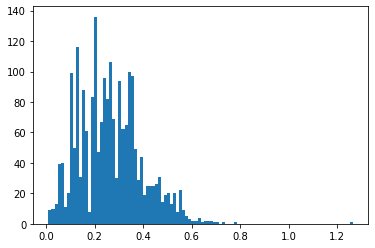

In [10]:
_ = plt.hist(zb['Z'], bins=100)

In [11]:
#ww = np.where(zb['Z'] < 0.1)[0]
ww = np.where(zb['Z'] < 0.05)[0]
#ww = np.where((zb['Z'] > 0.2) * (zb['Z'] < 0.3))[0]
print(ww)
zb[ww]

[   3   44  137  140  288  334  467  493  575  594  626  633  721  725
  734  778  787  821  885  920  927 1085 1204 1217 1280 1484 1560 1564
 1575 1588 1590 1653 1668 1676 1729 1732 1820 1849 1886 1973 2043 2090
 2096 2097]


TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32
35191325326313983,9540.85826280713,666.5421739670386 .. 35.73752467606016,0.021251042067577414,3.521659506053375e-06,0,7928,GALAXY,,10,1343.1988827884197,0,1
35191328597869309,9463.848334237933,556.9767512005826 .. 24.64836993618624,0.04748949568772229,5.306667264465084e-06,0,7928,GALAXY,,10,817.9715269356966,0,1
35191331848457495,10198.036368608475,2603.57634333831 .. 93.97063725756342,0.03098297480947576,1.1465586356446426e-06,0,7927,GALAXY,,10,18585.09018969536,0,1
35191331852648474,9176.581294715405,754.0886624297233 .. 26.10801409303115,0.047256516965572634,3.6722221601304173e-06,0,7929,GALAXY,,10,2058.8886085152626,0,1
35191328589481777,10119.687701556832,754.1266383524235 .. 2.2197650730854486,0.03190647039394827,5.752547167980751e-06,0,7927,GALAXY,,10,1350.1576255820692,0,1
35191331840067186,10267.425126615446,69.89733000044632 .. -8.313109319646504,0.03213849486397135,2.6510384451780905e-05,0,7902,GALAXY,,10,62.36143399449065,0,1
35191338274130602,10442.136381715536,446.2433954931065 .. 16.34342346856815,0.036792909677375925,4.403958029356015e-06,0,7928,GALAXY,,10,1109.0213572084904,0,1
35191341457606458,10503.391706823371,282.5705180863923 .. 7.6953608284369395,0.03354348851794582,1.5290324058179855e-05,0,7928,GALAXY,,10,172.11227975878865,0,1
35191341445024156,10029.532909348607,952.577228044847 .. -20.216026957333078,0.04646145872256755,5.780669010084203e-06,0,7914,GALAXY,,10,1918.063831742853,0,1


(3871.9073972735, 4081.1996890180135)

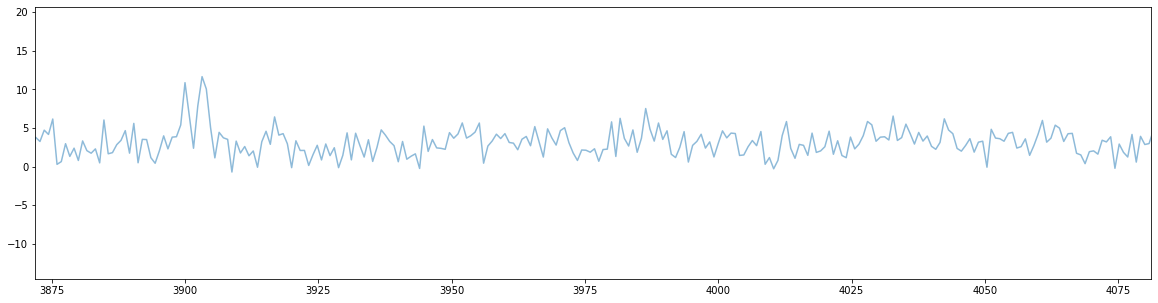

In [12]:
#iobj = ww[110] # z=0.44 this works!
iobj = ww[8]
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(specobj.wave['b'], specobj.flux['b'][iobj], alpha=0.5)
ax.plot(specobj.wave['r'], specobj.flux['r'][iobj],color ='tab:red', alpha=0.5)
ax.plot(specobj.wave['z'], specobj.flux['z'][iobj],color = 'tab:brown', alpha=0.5)
ax.set_xlim(np.array([3700, 3900]) * (1+zb[iobj]['Z']))
#ax.set_xlim(np.array([4950, 5050]) * (1+zb[iobj]['Z']))
#ax.set_xlim(np.array([6500, 6600]) * (1+zb[iobj]['Z']))

In [13]:
zb[iobj]

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32
35191341445024156,10029.532909348607,952.577228044847 .. -20.216026957333078,0.04646145872256755,5.780669010084203e-06,0,7914,GALAXY,,10,1918.063831742853,0,1


### Model the stellar continuum

#### Next steps

* Write down a data model for the continuum and emission-line fitting results.

* Improved (iterative) continuum-fitting:
  - Implement weighted fitting.
  - Mask pixels around emission lines.
  - Update the continuum redshift using cross-correlation. 
  - Resample to constant log-lamba and solve for the velocity dispersion.
  - Need to be careful because several of these steps will be a function of S/N.
  - The last continuum fit should be a non-linear fit which includes dust attenuation.

* Generate the residual (emission-line) spectrum.
  - Instantiate an astropy.modeling class with the suite of strong emission lines.
  - Start with all the lines tied together then separate out the forbidden and recombination lines.

#### Templates

In [31]:
def _smooth_and_resample(args):
    """Wrapper for the multiprocessing."""
    return smooth_and_resample(*args)

def smooth_and_resample(sspflux, sspwave, galwave, galR):
    """
    sspflux[npix] - redshifted SSP template
    sspwave[npix] - redshifted SSP wavelength
    
    """
    from desispec.interpolation import resample_flux
    return galR.dot(resample_flux(galwave, sspwave, sspflux))

class CKCz14(object):
    """Class to handle the CKCz14 SSPs.
    
    The SSPs have been converted to FITS format using the script fsps2fits.py
    
    """
    def __init__(self, metallicity='Z0.0190', minwave=0.0, maxwave=1e4, verbose=True):
        from astropy.table import Table
        from astropy.cosmology import FlatLambdaCDM

        self.cosmo = FlatLambdaCDM(H0=70, Om0=0.3)        

        self.metallicity = metallicity
        self.Z = float(metallicity[1:])
        self.library = 'CKC14z'
        self.isochrone = 'Padova' # would be nice to get MIST in here
        self.imf = 'Kroupa'

        # Don't hard-code the path!
        self.ssppath = '/global/cfs/cdirs/desi/users/ioannis/fsps'
        self.sspfile = os.path.join(ssppath, self.library, 'SSP_{}_{}_{}_{}.fits'.format(
            self.isochrone, self.library, self.imf, self.metallicity))

        if verbose:
            print('Reading {}'.format(self.sspfile))
        wave = fitsio.read(self.sspfile, ext='WAVE')
        flux = fitsio.read(self.sspfile, ext='FLUX')
        
        keep = np.where((wave >= minwave) * (wave <= maxwave))[0]
        self.wave = wave[keep]
        self.flux = flux[keep, :]
        self.info = Table(fitsio.read(self.sspfile, ext='METADATA'))

        self.nage = len(self.info['age'])
        self.npix = len(wave)
        
    def smooth_and_resample(self, galwave, galres, redshift, nproc=1):
        """Write me.
        
        galwave - list of wavelength array for each camera
        
        
        """
        oneplusz = 1 + redshift
                    
        # loop over cameras then SSP ages
        smoothflux = []
        for icamera in [0, 1, 2]: # iterate on cameras
            args = [(self.flux[:, iage] / oneplusz, self.wave * oneplusz, galwave[icamera], 
                     galres[icamera]) for iage in np.arange(self.nage)]
            with multiprocessing.Pool(nproc) as pool:
                smoothflux.append(np.array(pool.map(_smooth_and_resample, args)).T)

        return smoothflux
        #return np.concatenate((smoothflux[0], smoothflux[1], smoothflux[2]), axis=0)
        
ssp = CKCz14(metallicity='Z0.0190')

Reading /global/cfs/cdirs/desi/users/ioannis/fsps/CKC14z/SSP_Padova_CKC14z_Kroupa_Z0.0190.fits


In [156]:
class ContinuumModel(Fittable1DModel):
    #def __init__(self, ssp=None, **kwargs):
    def __init__(self, ebv, coeff0, coeff1, coeff2, coeff3, coeff4, 
                 coeff5, coeff6, coeff7, ssp=None, **kwargs):
    #def __init__(self, ebv=0.05, coeff0=0.1, coeff1=0.1, coeff2=0.1, coeff3=0.1, coeff4=0.1, 
    #             coeff5=0.1, coeff6=0.1, coeff7=0.1, ssp=None, **kwargs):
        """Class to hold the dusty continuum model.
    
        """     
        self.ssp = ssp
        self.dustslope = 0.7
        ebv = Parameter(name='ebv', default=0.05, bounds=(0.0, 0.5)) # reddening

        # dynamically create the coefficients for each continuum template
        #for ii in np.arange(ssp.nage):
        #    vars()['coeff{}'.format(ii)] = Parameter(name='coeff{}'.format(ii), default=1.0, bounds=(0.0, 1e20))
        coeff0 = Parameter(name='coeff0', default=0.1, bounds=(0.0, 1e20))
        coeff1 = Parameter(name='coeff1', default=0.1, bounds=(0.0, 1e20))
        coeff2 = Parameter(name='coeff2', default=0.1, bounds=(0.0, 1e20))
        coeff3 = Parameter(name='coeff3', default=0.1, bounds=(0.0, 1e20))
        coeff4 = Parameter(name='coeff4', default=0.1, bounds=(0.0, 1e20))
        coeff5 = Parameter(name='coeff5', default=0.1, bounds=(0.0, 1e20))
        coeff6 = Parameter(name='coeff6', default=0.1, bounds=(0.0, 1e20))
        coeff7 = Parameter(name='coeff7', default=0.1, bounds=(0.0, 1e20))
        print(ebv)
        
        #super(ContinuumModel, self).__init__(**kwargs)
        super(ContinuumModel, self).__init__(ebv.default, coeff0.default, coeff1.default, coeff2.default, 
                                             coeff3.default, coeff4.default, coeff5.default, 
                                             coeff6.default, coeff7.default, **kwargs)
        #super(ContinuumModel, self).__init__(ebv=ebv.default, coeff0=coeff0.default, coeff1=coeff1.default, coeff2=coeff2.default, 
        #                                     coeff3=coeff3.default, coeff4=coeff4.default, coeff5=coeff5.default, 
        #                                     coeff6=coeff6.default, coeff7=coeff7.default, **kwargs)

    def evaluate(self, wave, ebv, coeff0, coeff1, coeff2, coeff3, coeff4, coeff5, 
                 coeff6, coeff7):
        #pdb.set_trace()
        #ebv, coeffs = args[0], args[1:] # continuum coefficients
        pdb.set_trace()
        #sspflux = np.concatenate(self.redshift_smooth_and_resample(), axis=0)
        #continuum_model = sspflux.dot(coeffs)            
        #return continuum_model

In [157]:
#CM = ContinuumModel(FC.ssp)

In [159]:
#FC = FitContinuum(ssp, specobj, zb, 0, 1)
#CM = ContinuumModel(FC.ssp)
#FC.fit_continuum(CM)

In [161]:
class ContinuumModel(Fittable1DModel):
    from astropy.modeling import Parameter
    ebv = Parameter(name='ebv', default=0.05, bounds=(0.0, 0.5)) # reddening
    
    # dynamically create the 
    for ii in np.arange(7):
        vars()['coeff{}'.format(ii)] = Parameter(name='coeff{}'.format(1), default=1.0, bounds=(0.0, 1e20))# for ii in np.arange(7)
        
    def __init__(self):
        pass
        #self.slope = 0.7
        #super(ContinuumModel, self).__init__(*args, **coeffs)
             
    def evaluate(self, wave, *args):
        return args
        #sspflux = np.concatenate(self.redshift_smooth_and_resample(), axis=0)
        #coeffs = args[2:] # continuum coefficients
        #continuum_model = sspflux.dot(coeffs)            
        #return continuum_model
        
CM = ContinuumModel()
CM.param_names

('ebv', 'coeff0', 'coeff1', 'coeff2', 'coeff3', 'coeff4', 'coeff5', 'coeff6')

In [162]:
from astropy.modeling import Fittable1DModel, Parameter
class LineModel():
    def __init__(self, bob=10, **kwargs):
        slope = Parameter()
        intercept = Parameter()
        
        self.bob = bob
        super(LineModel, self).__init__(**kwargs)
        
    def evaluate(self, x, *args):
        print(args)
        slope, intercept = args[0], args[1]
        return slope * x + intercept

LM = LineModel()
LM.evaluate(np.arange(3), 1.0, 0.1)
LM.bob

(1.0, 0.1)


10

In [197]:
class FitContinuum():
    def __init__(self, ssp, specobj, zbest, iobj=0, nproc=1):
        """Model the stellar continuum.
    
        ssp - CKCz14 Class (fixed metallicity)
        specobj - Spectra Class data
        zbest - astropy Table with redshift info
        iobj - index of object to fit
        nproc - number of cores to use for multiprocessing
    
        """     
        from astropy.modeling import Parameter
        from desispec.resolution import Resolution

        self.nproc = nproc
        self.ssp = ssp
        
        # Select and repackage the spectrum we want to fit.
        self.npix, self.galwave, self.galflux, self.galivar, self.galres = [], [], [], [], []
        for camera in ('b', 'r', 'z'):
            self.npix.append(len(specobj.wave[camera]))
            self.galwave.append(specobj.wave[camera])
            self.galflux.append(specobj.flux[camera][iobj, :])
            self.galivar.append(specobj.ivar[camera][iobj, :])
            self.galres.append(Resolution(specobj.resolution_data[camera][iobj, :, :]))
            #self.galres.append(specobj.resolution_data[camera][iobj, :, :])
            
        self.zredrock = zbest['Z'][iobj]
            
    def redshift_smooth_and_resample(self, plot=False):
        """Redshift, convolve with the spectral resolution, and 
        resample in wavelength.
        
        """
        sspflux = self.ssp.smooth_and_resample(self.galwave, 
                                               self.galres, 
                                               self.zredrock, 
                                               nproc=self.nproc) # [npix, nage]
        
        if plot:
            ww = 110
            plt.plot(self.ssp.wave * (1+self.zredrock), self.ssp.flux[:, ww], color='gray', alpha=0.5)
            for ii in [0, 1, 2]: # iterate over cameras
                plt.plot(self.galwave[ii], sspflux[ii][:, 110], color='k')
            plt.xlim(3900, 4000)
            
        return sspflux
        
    def fit_fnnls(self, plot=False):
        """Fit using fast NNLS.
        https://github.com/jvendrow/fnnls
        
        """
        from fnnls import fnnls
        
        sspflux = np.concatenate(self.redshift_smooth_and_resample(), axis=0)
        if True:
            ebv, dustslope = 0.3, -0.7
            galwave = np.hstack(self.galwave)
            klambda = 5.9 * (galwave / 5500)**dustslope
            atten = 10**(-0.4 * ebv * klambda)
            sspflux *= atten[:, None]
        
        galflux = np.hstack(self.galflux)
        galivar = np.hstack(self.galivar)

        # Do a fast initial fit of the stellar continuum.
        # ToDo: mask emission lines!
        self.fnnls_coeffs = fnnls(sspflux * np.sqrt(galivar[:, None]), galflux * np.sqrt(galivar))[0]
        continuum = sspflux.dot(self.fnnls_coeffs)
        print('Compute chi2 and store the coeffs.')
        
        self.continuum = []
        npix = np.hstack([0, self.npix])
        for ii in [0, 1, 2]: # iterate over cameras
            ipix = np.sum(npix[:ii+1])
            jpix = np.sum(npix[:ii+2])
            self.continuum.append(continuum[ipix:jpix])

        if plot:
            galwave = np.hstack(self.galwave)

            fig, ax = plt.subplots(figsize=(14, 8))
            for ii in [0, 1, 2]: # iterate over cameras
                ax.plot(self.galwave[ii], self.galflux[ii])
            ax.plot(galwave, continuum, alpha=0.5, color='k')
            #ax.set_xlim(3850, 3950)
            
        return continuum    
        
    def fit_continuum(self, ContinuumModel):
        """More detailed continuum model fit, including dust attenuation.
        
        """
        from astropy.modeling import fitting
                
        fitter = fitting.LevMarLSQFitter()
        
        wave = np.hstack(self.galwave)
        flux = np.hstack(self.galflux)
        ivar = np.hstack(self.galivar)
        
        weights = 1 / np.sqrt(ivar)
        continuum_fit = fitter(ContinuumModel, wave, flux, weights=1/np.sqrt(ivar))

        pdb.set_trace()

Compute chi2 and store the coeffs.
CPU times: user 423 ms, sys: 793 ms, total: 1.22 s
Wall time: 2.08 s
[8.57400979e+08 1.89524370e+09 7.18147150e+09 1.10775393e+11
 9.32951366e+10] [0.00281838 0.00794328 0.22387211 0.7943283  1.2589254 ]


0.9675904325328206

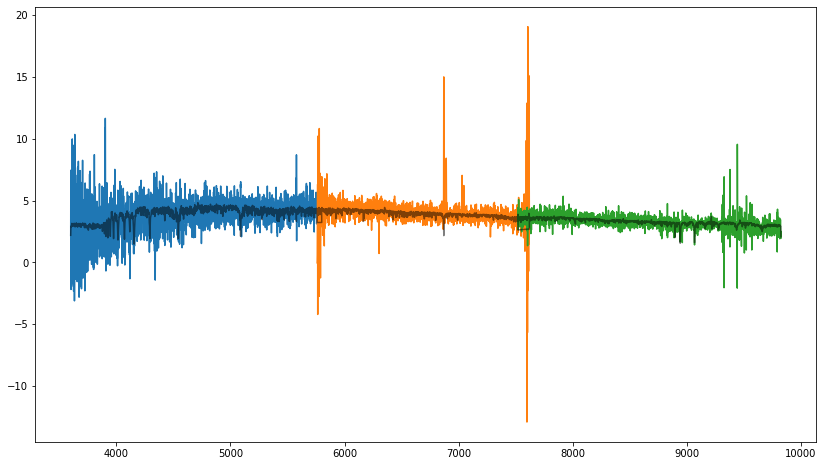

In [198]:
FC = FitContinuum(ssp, specobj, zb, iobj=iobj)
%time continuum = FC.fit_fnnls(plot=True)
ww = FC.fnnls_coeffs > 0
weight = FC.fnnls_coeffs[ww]
print(weight, ssp.info['age'][ww].data / 1e9)
np.sum(weight * ssp.info['age'][ww]) / np.sum(weight) / 1e9

In [ ]:
len(FC.galres)

## Emission-line modeling

* https://docs.astropy.org/en/stable/modeling/example-fitting-constraints.html#tied
* https://docs.astropy.org/en/stable/modeling/new-model.html
* https://docs.astropy.org/en/stable/modeling/compound-models.html#parameters

In [ ]:
def get_linetable():
    # read this from a file!

    linetable = Table()
    linetable['name'] = ['oii_3726', 'oii_3729', 
                         'oiii_4959', 'oiii_5007', 
                         'nii_6548', 'nii_6584', 
                         'hdelta', 'hgamma', 'hbeta', 'halpha']
    linetable['flux'] = [0.73, 1.0, 
                         1.0, 2.875, 
                         1.0, 2.936, 
                         0.259, 0.468, 1.0, 2.863]
    linetable['restwave'] = [3727.092, 3729.874, 
                             4960.295, 5008.239, 
                             6549.852, 6585.277, 
                             4102.892, 4341.684, 4862.683, 6564.613]
    return linetable    

class EMLineModel(astropy.modeling.Fittable1DModel):
    """Class to model the emission-line spectra.

    """
    from astropy.table import Table, Column
    from astropy.modeling import Parameter

    # NB! The order of the parameters here matters!
    zline = Parameter(name='zline', default=0.1, bounds=(-0.05, 2.0)) # line-redshift
    linesigma = Parameter(name='linesigma', default=50.0, bounds=(0.1, 350)) # line-sigma [km/s]

    # Fragile because the lines are hard-coded--
    oii_3726_flux = Parameter(name='oii_3726_flux', default=0.73)
    oii_3729_flux = Parameter(name='oii_3729_flux', default=1.0)
    oiii_4959_flux = Parameter(name='oiii_4959_flux', default=1.0)
    oiii_5007_flux = Parameter(name='oiii_5007_flux', default=2.8875)
    nii_6548_flux = Parameter(name='nii_6548_flux', default=1.0)
    nii_6584_flux = Parameter(name='nii_6584_flux', default=2.936)
    hdelta_flux = Parameter(name='hdelta_flux', default=0.259)
    hgamma_flux = Parameter(name='hgamma_flux', default=0.468)
    hbeta_flux = Parameter(name='hbeta_flux', default=1.0)
    halpha_flux = Parameter(name='halpha_flux', default=2.863)

    # tie the [NII] and [OIII] line-strengths together
    def tie_oiii(model):
        return model.oiii_5007_flux / 2.8875
    oiii_4959_flux.tied = tie_oiii

    def tie_nii(model):
        return model.nii_6584_flux / 2.936
    nii_6548_flux.tied = tie_nii
    
    def __init__(self, zline=zline.default, linesigma=linesigma.default,
                 oii_3726_flux=oii_3726_flux.default, 
                 oii_3729_flux=oii_3729_flux.default, 
                 oiii_4959_flux=oiii_4959_flux.default, 
                 oiii_5007_flux=oiii_5007_flux.default, 
                 nii_6548_flux=nii_6548_flux.default, 
                 nii_6584_flux=nii_6584_flux.default, 
                 hdelta_flux=hdelta_flux.default, 
                 hgamma_flux=hgamma_flux.default, 
                 hbeta_flux=hbeta_flux.default, 
                 halpha_flux=halpha_flux.default, 
                 emlineR=None, npixpercamera=None, **kwargs):
        """Initialize the emission-line model.
        
        emlineR - 
        
        """

        self.linetable = get_linetable()
        self.emlineR = emlineR
        self.npixpercamera = np.hstack([0, npixpercamera])
        
        super(EMLineModel, self).__init__(
            zline=zline, linesigma=linesigma,
            oii_3726_flux=oii_3726_flux,
            oii_3729_flux=oii_3729_flux,
            oiii_4959_flux=oiii_4959_flux,
            oiii_5007_flux=oiii_5007_flux,
            nii_6548_flux=nii_6548_flux,
            nii_6584_flux=nii_6584_flux,
            hdelta_flux=hdelta_flux,
            hgamma_flux=hgamma_flux,
            hbeta_flux=hbeta_flux,
            halpha_flux=halpha_flux, **kwargs)
        
    def evaluate(self, log10wave, *args):
        """Evaluate the emission-line model.
        
        """ 
        zline, linesigma = args[0], args[1]

        linenames = self.linetable['name'].data
        linefluxes = args[2:]
        
        emlinemodel = []
        for ii in [0, 1, 2]: # iterate over cameras
            ipix = np.sum(self.npixpercamera[:ii+1])
            jpix = np.sum(self.npixpercamera[:ii+2])
            _emlinewave = log10wave[ipix:jpix]
            _emlinemodel = np.zeros_like(_emlinewave)
            
            for linename, lineflux in zip(linenames, linefluxes):
                restlinewave = self.linetable[self.linetable['name'] == linename]['restwave'][0]
                zlinewave = np.log10(restlinewave * (1.0 + zline)) # redshifted wavelength [log-10 Angstrom]
                log10sigma = linesigma / C_LIGHT / np.log(10)      # line-width [log-10 Angstrom]
                lineamp = lineflux / (np.sqrt(2.0 * np.pi) * log10sigma)
            
                # Construct the spectrum [erg/s/cm2/A, rest]
                ww = np.abs(_emlinewave - zlinewave) < 20 * log10sigma
                if np.count_nonzero(ww) > 0:
                    #print(linename, 10**zlinewave, 10**_emlinewave[ww].min(), 10**_emlinewave[ww].max())
                    _emlinemodel[ww] += lineamp * np.exp(-0.5 * (_emlinewave[ww]-zlinewave)**2 / log10sigma**2)

            # optionally convolve with the spectral resolution
            if self.emlineR is not None:
                _emlinemomdel = self.emlineR[ii].dot(_emlinemodel)
            
            #plt.plot(10**_emlinewave, _emlinemodel)
            #plt.plot(10**_emlinewave, self.emlineR[ii].dot(_emlinemodel))
            #plt.xlim(3870, 3920) ; plt.show()
            #pdb.set_trace()
            emlinemodel.append(_emlinemodel)

        return np.hstack(emlinemodel)

In [ ]:
EM = EMLineModel(zline=FC.zredrock, linesigma=50.0, npixpercamera=FC.npix, emlineR=FC.galres)
ss = EM.evaluate(np.log10(np.hstack(FC.galwave)), EM.zline, EM.linesigma, 0.5, 1.0, 0.5, 1.0, 0.2, 0.2, 0.5, 0.5, 1.0, 2.0)
plt.plot(np.hstack(FC.galwave), ss)

In [ ]:
#plt.plot(np.hstack(galwave), np.hstack(FC.continuum))
#plt.plot(np.hstack(galwave), np.hstack(FC.galflux))
plt.errorbar(np.hstack(galwave), np.hstack(FC.galflux), yerr=1/np.sqrt(np.hstack(FC.galivar)))
plt.xlim(3870, 3920)

In [ ]:
class EMLineFit(object):
    """Class to fit an emission-line spectrum.

    """
    def __init__(self, nball=10, chi2fail=1e6):
        """Write me
        
        """
        from astropy.modeling import fitting
        self.fitter = fitting.LevMarLSQFitter()
        self.nball = nball
        self.chi2fail = chi2fail
                
    def chi2(self, bestfit, emlinewave, emlineflux, emlineivar):
        """Compute the reduced chi^2."""
        dof = len(emlinewave) - len(bestfit.parameters)
        emlinemodel = bestfit(emlinewave)
        chi2 = np.sum(emlineivar * (emlineflux - emlinemodel)**2) / dof
        return chi2
    
    def fit(self, EMLineModel, FC, verbose=False):
        """Perform the fit minimization / chi2 minimization.
        
        EMLineModel object
        FC - ContinuumFit object
        
        """       
        emlinewave = np.hstack(FC.galwave)
        emlineflux = np.hstack(FC.galflux) - np.hstack(FC.continuum)
        emlineivar = np.hstack(FC.galivar)
        
        weights = 1 / np.sqrt(emlineivar)
        bestfit = self.fitter(EMLineModel, np.log10(emlinewave), 
                              emlineflux, weights=weights)
        chi2 = self.chi2(bestfit, emlinewave, emlineflux, emlineivar).astype('f4')
        
        # Pack the results in a dictionary and return.
        # https://gist.github.com/eteq/1f3f0cec9e4f27536d52cd59054c55f2
        result = {
            'converged': False,
            'fit_message': self.fitter.fit_info['message'],
            'nparam': len(EMLineModel.parameters),
            'npix': len(emlinewave),
            'dof': len(emlinewave) - len(EMLineModel.parameters),
            'chi2': chi2,
        }
        #for param in bestfit.param_names:
        #    result.update({param: getattr(bestfit, param).value})
        
        # uncertainties
        if self.fitter.fit_info['param_cov'] is not None:
            cov = self.fitter.fit_info['param_cov']
            unc = np.diag(cov)**0.5
            result['converged'] = True
        else:
            cov = np.zeros( (nparams, nparams) )
            unc = np.zeros(nparams)

        # https://github.com/astropy/astropy/issues/7202
        #err_params = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        #err = model.copy()
        #fitting._fitter_to_model_params(err, err_params)            
            
        count = 0
        for ii, pp in enumerate(bestfit.param_names):
            pinfo = getattr(bestfit, pp)
            result.update({bestfit.param_names[ii]: bestfit.parameters[ii].astype('f4')})
            if pinfo.fixed:
                result.update({bestfit.param_names[ii]+'_err': np.float32(0.0)})
            elif pinfo.tied:
                pass # hack! see https://github.com/astropy/astropy/issues/7202
            else:
                result.update({bestfit.param_names[ii]+'_err': unc[count].astype('f4')})
                count += 1
        
        result.update({
            'emlinemodel': bestfit(np.log10(emlinewave)),
        })
        
        return result

EM = EMLineModel(zline=FC.zredrock, linesigma=50.0, npixpercamera=FC.npix, emlineR=FC.galres)

result = EMLineFit().fit(EM, FC)
#bestemlinefit = EMFit.fitter(np.log10(EMFit.emlinewave))

#print(bestemlinefit, rr)
print(result)
#bestemlinefit = EMFit()

In [ ]:
galwave = np.hstack(FC.galwave)
galflux = np.hstack(FC.galflux) - np.hstack(FC.continuum)

fig, ax = plt.subplots(1, 4, figsize=(16, 5))#, sharey=True)
for xx, minwave, maxwave in zip(ax, (3725, 4850, 4950, 6550), (3730, 4870, 5015, 6595)):
    wmin, wmax = np.array([minwave, maxwave]) * (1+FC.zredrock) + np.array([-20, +20])
    indx = np.where((galwave > wmin) * (galwave < wmax))[0]
    xx.plot(galwave[indx], galflux[indx])
    xx.plot(galwave[indx], result['emlinemodel'][indx])
    #xx.set_xlim(xlim)
    xx.set_ylim(-3, 13)
plt.subplots_adjust(wspace=0.05)

In [ ]:
EMFit.initfit.param_names
getattr(EMFit.initfit, 'zline').value

In [ ]:
4340*1.044, 0.0013778722982341204/0.0005611314765764429

In [ ]:
stop

### Obsolete / sandbox below here

In [ ]:
class FSPSmodel(object):
    """initialize an FSPS StellarPopulation class. (relegated)
    
    """
    def __init__(self):
        import fsps
        self.ssp = fsps.StellarPopulation(
            zcontinuous=1,          # interpolate metallicities
            sfh=0,                  # 0=SSP; 4=delayed tau
            dust_type=0,            # 0=power law; 2=Calzetti+00
            dust_index=0.0,         # only used if dust_type=0
            imf_type=1)             # 0=Salpeter+55; 1=Chabrier+03
        
def _get_fsps_spec():
    tage = np.array([0.001, 0.05, 0.1, 0.3, 1.0, 5.0, 13.0])
    for ii, tt in enumerate(tage):
        wave, _spec = ssp.get_spectrum(tage=tt, peraa=True) # [Lsun/AA]
        if ii == 0:
            spec = np.zeros((len(tage), len(_spec)))
        spec[ii, :] = _spec
    return spec

#ssp = FSPSmodel().ssp
#plt.plot(wave, spec[5, :])
#plt.xlim(3000, 9000)

In [ ]:
import astropy.modeling
from scipy import constants
C_LIGHT = constants.c / 1000.0 # [km/s]
from astropy.modeling.models import RedshiftScaleFactor, Gaussian1D        
from astropy.modeling import models, fitting

def get_linetable():
    # read this from a file!
    nline = 6
    linetable = Table()
    #line.add_column(Column(name='name', length=nline))
    #line.add_column(Column(name='wave', dtype='f8', length=nline))
    #line.add_column(Column(name='amp', dtype='f8', length=nline))
    linetable['name'] = ['oii_3726', 'oii_3729', 'oiii_4959', 'oiii_5007', 'hbeta', 'halpha']
    linetable['flux'] = [0.73, 1.0, 1.0, 2.875, 1.0, 2.863]
    linetable['restwave'] = [3727.092, 3729.874, 4960.295, 5008.239, 4862.683, 6564.613]
    return linetable    

class EMLineModel(astropy.modeling.Fittable1DModel):
    """Class to model the emission-line spectra.

    """
    from astropy.table import Table, Column
    from astropy.modeling import Parameter

    # NB! The order of the parameters here matters!
    zline = Parameter(name='zline', default=0.1, bounds=(-0.05, 2.0)) # line-redshift
    linesigma = Parameter(name='linesigma', default=100.0, bounds=(10, 350)) # line-sigma [km/s]
    #print(linesigma, zline)

    linetable = get_linetable()
    
    linemodel = None
    for line in linetable:
        _linemodel = self.oneline(line['name'], line['restwave'], line['flux'], zline, linesigma)
        if linemodel is None:
            linemodel = _linemodel
        else:
            linemodel += _linemodel
    
    def __init__(self, linemodel):
        self.linemodel = linemomdel
        super(EMLineModel, self).__init__(linemodel)

    #def __init__(self, zline=zline.default, linesigma=linesigma.default):
    #    self.linetable = get_linetable()
    #    super(EMLineModel, self).__init__(zline=zline, linesigma=linesigma)
        
    #def oneline(self, name, restwave, flux, zline, linesigma):
    @staticmethod
    def oneline(name, restwave, flux, zline, linesigma):
        """Create a single Gaussian emission line in log-lambda space."""
        
        zlogwave = np.log10(restwave * (1.0 + zline))
        
        log10sigma = linesigma / C_LIGHT / np.log(10) # line-width [log-10 Angstrom]
        amp = flux / restwave / np.log10(10)     # line-amplitude [erg/s/cm2/A]
        amp /= np.sqrt(2.0 * np.pi) * log10sigma # [erg/s/A]
        #print(name, amp, zlogwave, line10sigma)
    
        return models.Gaussian1D(amplitude=amp, mean=zlogwave, stddev=log10sigma, name=name)
        
    #def evaluate(self, wave, zline, linesigma):
    @staticmethod
    def evaluate(wave, zline, linesigma, oii_3726):
        """Evaluate the emission-line model.
        
        """
        #linemodel = None
        #for line in self.linetable:
        #    _linemodel = self.oneline(line['name'], line['restwave'], line['flux'], zline, linesigma)
        #    if linemodel is None:
        #        linemodel = _linemodel
        #    else:
        #        linemodel += _linemodel

        emlinemodel = linemodel(wave)
        #emlinemodel = linemodel(wave)
        #print(zline, linesigma, emlinemodel)
        return linemodel
        #return emlinemodel
    
class EMLineFit(object):
    """Class to fit an emission-line spectrum.

    """
    def __init__(self, emwave, emlineflux, emlineivar, zline=0.1, 
                 linesigma=100.0, nball=10, chi2fail=1e6):

        # initialize the fitter
        self.fitter = fitting.LevMarLSQFitter()
        self.nball = nball
        self.chi2fail = chi2fail
        
        self.emwave = emwave
        self.emlineflux = emlineflux
        self.emlineivar = emlineivar

        # initialize the fit
        self.initfit = EMLineModel(zline=zline, linesigma=linesigma)
        
    def chi2(self, bestfit):
        """Compute the reduced chi^2."""
        dof = len(self.emwave) - len(bestfit.parameters)
        emlinemodel = bestfit(self.emwave)
        chi2 = np.sum( self.emlineivar * (self.emlineflux - emlinemodel)**2) / dof
    
    def fit(self, verbose=False):
        """Perform the chi2 minimization.
        
        """
    
        # initialize the output dictionary
        # initialize the output dictionary
        result = {
            'success': False,
            'converged': False,
            'chi2': self.chi2fail, # initial value
            'dof': len(self.emwave) - len(self.initfit.parameters),
            }

        weights = 1 / np.sqrt(self.emlineivar)
        ballfit = self.fitter(self.initfit, np.log10(self.emwave), 
                              self.emlineflux, weights=weights)
        bestfit = ballfit(np.log10(self.emwave))
        bestfit = self.initfit(np.log10(self.emwave))
        #print(ballfit)
        return ballfit, bestfit

zinit = zb[iobj]['Z']
EM = EMLineModel(zline=zinit, linesigma=50.0)
#print(EM)
bb = EM.evaluate(np.log10(bigwave), zline=zinit, linesigma=50.0)
bb
#wave = np.arange(3500.0, 7000, 0.1)
#plt.plot(bigwave, EM.evaluate(np.log10(bigwave), zline=zinit, linesigma=50.0))
#plt.xlim(3850, 4000)

In [ ]:
from astropy.modeling import models, fitting

# Create Gaussian1D models.
oii_3726 = models.Gaussian1D(amplitude=0.73, mean=3727.092*onez, stddev=1.0, name='oii_3726')
oii_3729 = models.Gaussian1D(amplitude=1.0, mean=3729.874*onez, stddev=1.0, name='oii_3729')

# Tie the ratio of the intensity
#def tie_fluxl(model):
#    return model.amplitude_2 / 3.1
#o3_1.amplitude.tied = tie_fluxl

# Tie the wavelengths together
def tie_wave(model):
    return model.mean_0 * oii_3729.mean.value / oii_3726.mean.value

oii_3729.mean.tied = tie_wave

# Create a compound model with all the lines and then fit.
linemodel = oii_3726 + oii_3729

fit = fitting.LevMarLSQFitter()
fitmodel = fit(linemodel, bigwave, emlineflux)
model = fitmodel(bigwave)

plt.plot(bigwave, emlineflux)
plt.plot(bigwave, model, color='red')
plt.axhline(y=0, color='k')
plt.xlim(3870, 3920)
#plt.xlim(5200, 5250)

In [ ]:
#from astropy.modeling.models import RedshiftScaleFactor, Gaussian1D        
#from astropy.modeling import models, fitting
  
class EMLineFit(object):
    """Class to fit an emission-line spectrum.

    """
    def __init__(self, nball=10, chi2fail=1e6):
        self.fitter = fitting.LevMarLSQFitter()
        self.nball = nball
        self.chi2fail = chi2fail
                
    def chi2(self, bestfit, emlinewave, emlineflux, emlineivar):
        """Compute the reduced chi^2."""
        dof = len(emlinewave) - len(bestfit.parameters)
        emlinemodel = bestfit(emlinewave)
        chi2 = np.sum(emlineivar * (emlineflux - emlinemodel)**2) / dof
        return chi2
    
    def fit(self, initfit, emlinewave, emlineflux, emlineivar, verbose=False):
        """Perform the fit minimization / chi2 minimization.
        
        """       
        weights = 1 / np.sqrt(emlineivar)
        bestfit = self.fitter(initfit, np.log10(emlinewave), 
                              emlineflux, weights=weights)
        chi2 = self.chi2(bestfit, emlinewave, emlineflux, emlineivar)
        
        # pack the results and return
        result = {
            'success': False,
            'converged': False,
            'chi2': chi2,
            'nparam': len(initfit.parameters),
            'npix': len(emlinewave),
            'dof': len(emlinewave) - len(initfit.parameters),
        }
        for param in bestfit.param_names:
            result.update({param: getattr(bestfit, param).value})
        
        result.update({
            'emlinemodel': bestfit(np.log10(emlinewave)),
        })
        
        return result

zinit = zb[iobj]['Z']
EM = EMLineModel(zline=zinit, linesigma=50.0, emlineR='bob')
print(EM)
#bb = EM.evaluate(np.log10(bigwave), zline=zinit, linesigma=50.0)
#wave = np.arange(3500.0, 7000, 0.1)
#plt.plot(bigwave, EM.evaluate(np.log10(bigwave), zline=zinit, linesigma=50.0))
#plt.xlim(3850, 4000)

#cut = (bigwave > 3870) * (bigwave < 3920)
cut = np.ones_like(bigwave, bool)
plt.plot(bigwave[cut], emlineflux[cut])
#plt.plot(bigwave[cut], EM.evaluate(np.log10(bigwave[cut]), zline=zinit, linesigma=50.0))

#R = Resolution(resolution_data)

rr = EMLineFit().fit(EM, bigwave[cut], emlineflux[cut], bigivar[cut])
#bestemlinefit = EMFit.fitter(np.log10(EMFit.emlinewave))

#print(bestemlinefit, rr)
print(rr)
#bestemlinefit = EMFit()
plt.plot(bigwave[cut], rr['emlinemodel'])
#plt.xlim(3870, 3925)
#plt.xlim(6800, 6875)
#plt.xlim(4500, 4600) ; plt.ylim(-2, 4)
#plt.xlim(5100, 5300)
